In [19]:
#Tasks to pass this assignment with a grade 3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [93]:
#1. Read the csv/xl file into pandas data-frame
df = pd.read_excel("C:/Programming/IAI-eMaintenance-Assignment-2/train delays-1.xlsx")

In [228]:
#2. Feature engineering – add additional features to the dataset if required, explain !

#column for punctual/delayed <5min train is punctual (1) otherwise (0)
df["Punctual"] = (df["registered delay"] < 5).astype(int)

#function for grade 5 to represent delays as discrete variables
def delay_into_discrete(delay):
    if delay <= 5:
        return 0 
    elif delay <= 15:
        return 1 
    elif delay <= 30:
        return 2 
    elif delay <= 60:
        return 3
    else: return 4

df["DelayInterval"] = df["registered delay"].apply(delay_into_discrete)

#change to datetime for dt to work
df["Date"] = pd.to_datetime(df["Date"])
# new column for day of the week
df["WeekDay"] = df["Date"].dt.dayofweek
df["IsWeekend"] = df["WeekDay"] >= 5

# numerical days to categorical for readability
#day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#df['WeekDay'] = df['WeekDay'].map({i: day_names[i] for i in range(7)})
#columns for amount of delays for specific route, tågnr and place
df["RouteDelayCount"] = df.groupby("Route")["registered delay"].transform("count")
df["TrainDelayCount"] = df.groupby("Tågnr")["registered delay"].transform("count")
df["PlaceDelayCount"] = df.groupby("Place")["registered delay"].transform("count")

df.to_csv("outputBeforeGeopy.csv", index=False)


CAN PROB REMOVE THAT UNKNOWN ROUTE

In [95]:
#3. Data Pre-processing –Remove unnecessary data, explain!

#first column was empty so it got removed.
df.drop(columns=["Unnamed: 0", "Operator", "Train ID", "Train mission", "Reason code", "Reason code - level 1", "Reason code Level 2", "Reason code Level 3", "Train number", "Year"], axis=1, inplace=True)


#save to check the data
df.to_csv("outputBeforeGeopy.csv", index=False)

In [23]:
#4. Data visualisation – Fetching latitude and longitude of the places mentioned in the dataset

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
from tqdm import tqdm
tqdm.pandas()

geolocator = Nominatim(user_agent="train_delay", timeout=10)
geocode = RateLimiter(lambda query: geolocator.geocode(query, country_codes="SE"), min_delay_seconds=1)

#new dataframe with all places once
place_coords_df = pd.DataFrame({
    "Place": df["Place"].unique()
})

#new column with location of all places
place_coords_df["location"] = place_coords_df["Place"].progress_apply(geocode)

print(place_coords_df)

100%|██████████| 395/395 [06:34<00:00,  1.00it/s]

           Place                                           location
0       Storsund  (Storsund, Piteå kommun, Norrbottens län, Sver...
1         Vännäs  (Vännäs kommun, Västerbottens län, Sverige, (6...
2    Kirunavaara  (Kirunavaara, Holmajärvivägen, Kiruna kommun, ...
3        Gimonäs  (Gimonäs, Ålidhemsområdet, Umeå, Umeå kommun, ...
4        Rundvik  (Rundvik, Nordmalings distrikt, Nordmalings ko...
..           ...                                                ...
390      Ragunda  (Ragunda kommun, Jämtlands län, Sverige, (63.1...
391      Selsjön  (Selsjön, Selet, Luleå kommun, Norrbottens län...
392       Kaitum  (Kaitum, Gällivare kommun, Norrbottens län, Sv...
393      Tenhult  (Tenhult, Jönköpings kommun, 560 29, Sverige, ...
394       Moheda  (Moheda, Alvesta kommun, Kronobergs län, 342 6...

[395 rows x 2 columns]


In [24]:
#new column with lon/lat as a point (this format to prepare for the GeoDataFrame)
place_coords_df["point"] = place_coords_df["location"].apply(lambda loc: Point(loc.longitude, loc.latitude) if loc else None)
#merge the two dataframes to expand the original dataframe with location and point aswell
df = pd.merge(df, place_coords_df, on="Place", how="right")
df.to_csv('output.csv', index=False)

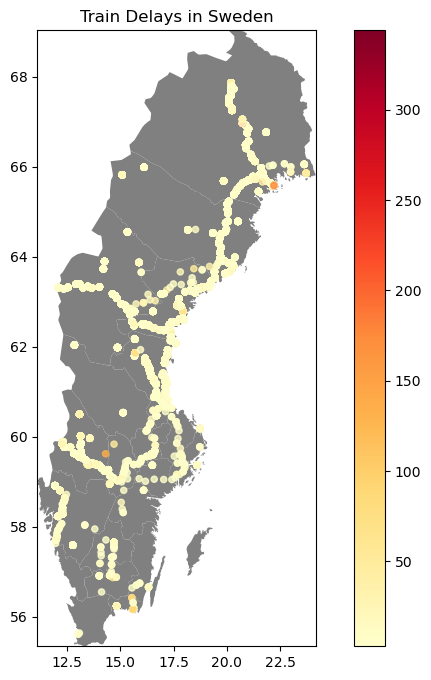

In [25]:
#4. Data visualisation – Plot the data spatially using the ‘geopandas’ library.
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry="point")
url = "C:/Programming/IAI-eMaintenance-Assignment-2/ne_10m_admin_1_states_provinces.zip"
world = gpd.read_file(url)
sweden = world[world["admin"] == "Sweden"]

gdf = gdf.set_crs('EPSG:4326', allow_override=True)

fig, ax = plt.subplots(figsize=(10, 8))
sweden.plot(ax=ax, color="grey")

gdf.plot(ax=ax, column="registered delay", cmap="YlOrRd", markersize=20, legend=True, alpha=0.8)
ax.set_xlim([sweden.bounds.minx.min(), sweden.bounds.maxx.max()])
ax.set_ylim([sweden.bounds.miny.min(), sweden.bounds.maxy.max()])
plt.title("Train Delays in Sweden")
plt.show()

SAME HERE

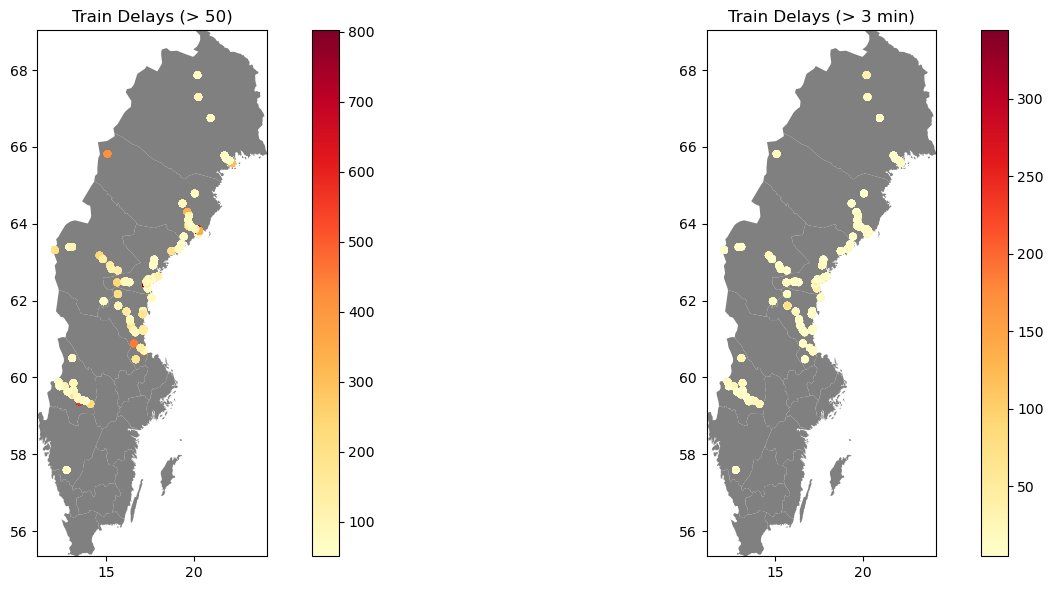

In [ ]:
#new gdf with only over 50 counted delays
gdf_filter = gdf[gdf["PlaceDelayCount"] > 50]

#plot of train delays that are above 3min (not punctual)
gdf_not_punctual = gdf_filter[gdf_filter["Punctual"] == 0]

# two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))  # Two plots side by side

#1 subplot
sweden.plot(ax=axes[0], color="grey")
gdf_filter.plot(ax=axes[0], 
                  column="PlaceDelayCount", 
                  cmap="YlOrRd", 
                  markersize=20, 
                  legend=True, 
                  alpha=0.8)
axes[0].set_xlim([sweden.bounds.minx.min(), sweden.bounds.maxx.max()])
axes[0].set_ylim([sweden.bounds.miny.min(), sweden.bounds.maxy.max()])
axes[0].set_title("Train Delays (> 50)")

#2 subplot
sweden.plot(ax=axes[1], color="grey")
gdf_not_punctual.plot(ax=axes[1], 
                      column="registered delay", 
                      cmap="YlOrRd", 
                      markersize=20, 
                      legend=True, 
                      alpha=0.8)
axes[1].set_xlim([sweden.bounds.minx.min(), sweden.bounds.maxx.max()])
axes[1].set_ylim([sweden.bounds.miny.min(), sweden.bounds.maxy.max()])
axes[1].set_title("Train Delays (> 3 min)")

plt.tight_layout()
plt.show()

SAME FOR THESE

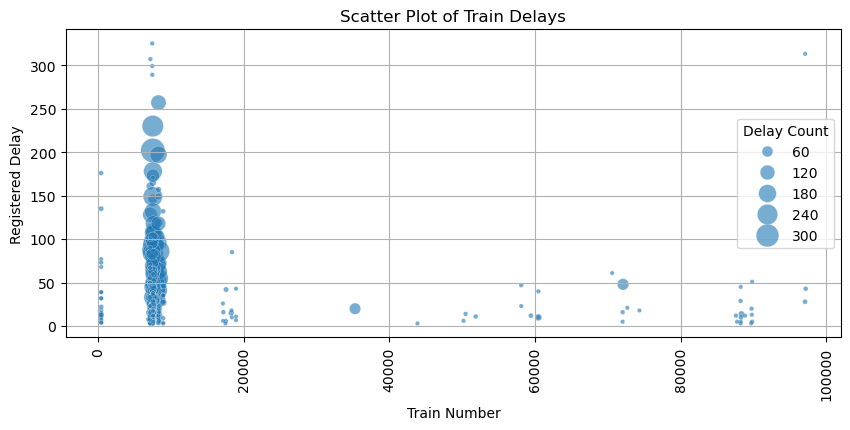

In [ ]:
# df with the max of registered delays by tågnr
delay_max = df.groupby("Tågnr")["registered delay"].max()

plt.figure(figsize=(10, 4))
sb.scatterplot(
    df,
    x="Tågnr",
    y=delay_max,
    alpha=0.6,
    size="TrainDelayCount",
    sizes=(10, 300)
)


plt.xlabel("Train Number")
plt.ylabel("Registered Delay")
plt.title("Scatter Plot of Train Delays")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title="Delay Count")

plt.show()

In [140]:
#created new df because I didnt want totaldelaytime as a column in original
train_delay_summ = df.groupby("Tågnr").agg(
    DelayCount=("registered delay", "count"),
    TotalDelayTime=("registered delay", "sum")
)

train_delay_summ_sort_tåg = train_delay_summ.sort_values(by=["DelayCount", "TotalDelayTime"], ascending=False)

print("Train with the highest delays:")
print(train_delay_summ_sort_tåg.head(10))

Train with the highest delays:
       DelayCount  TotalDelayTime
Tågnr                            
7154          338            3842
7509          288            1617
7152          263            2747
7417          249            2542
7412          235            1949
7510          227            1680
7151          215            2407
7410          198            1773
7107          181            1554
7519          181            1073


In [ ]:
#created new df because I didnt want totaldelaytime as a column in original
train_delay_summ = df.groupby("Route").agg(
    DelayCount=("registered delay", "count"),
    TotalDelayTime=("registered delay", "sum")
)

train_delay_summ_sort = train_delay_summ.sort_values(by=["DelayCount", "TotalDelayTime"], ascending=False)

print("Train with the highest delays:")
print( train_delay_summ_sort.head(10))

Train with the highest delays:
                 DelayCount  TotalDelayTime
Route                                      
SUC-ÖK-UÅ              1673           17244
STR-ÖS-SUC             1345            7943
TJT                    1336           19171
SUC-ÖS-STR             1300           10388
GÄVLE-LJUSDAL          1299            9081
UÅ-ÖK-SUC              1240           12186
-                      1135           21214
LJUSDAL-GÄVLE           924            4947
GÄVLE-SUNDSVALL         841            6982
LE-KMB                  749            7696


C:\Users\adam-\AppData\Local\Temp\ipykernel_12156\4248423037.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


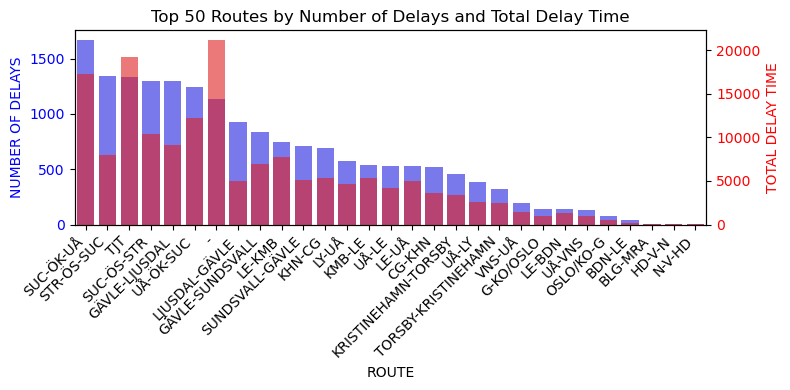

In [ ]:
#top 50 routes
train_delay_top_50 = train_delay_summ_sort.head(50)

# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))
sb.barplot(x=train_delay_top_50.index, y="DelayCount", data=train_delay_top_50, ax=ax1, color="blue", alpha=0.6)
ax1.set_xlabel("ROUTE")
ax1.set_ylabel("NUMBER OF DELAYS", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# snd axis
ax2 = ax1.twinx()
sb.barplot(x=train_delay_top_50.index, y="TotalDelayTime", data=train_delay_top_50, ax=ax2, color="red", alpha=0.6)
ax2.set_ylabel("TOTAL DELAY TIME", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.title("Top 50 Routes by Number of Delays and Total Delay Time")
plt.tight_layout()

plt.show()

C:\Users\adam-\AppData\Local\Temp\ipykernel_12156\1852284398.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


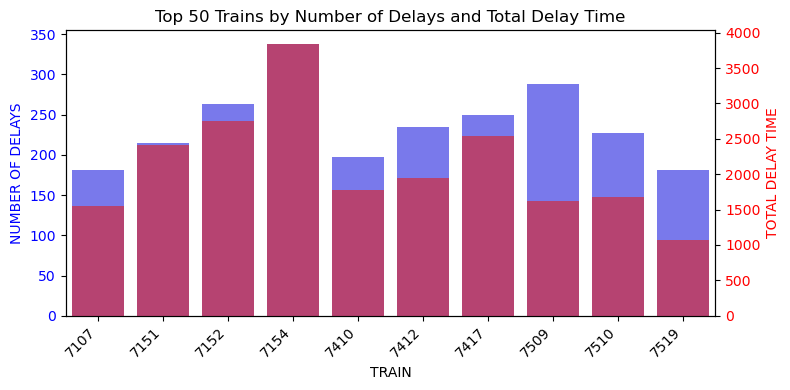

In [ ]:
#top 50 trains
top_50_trains = train_delay_summ_sort_tåg.head(10)

# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))
sb.barplot(x=top_50_trains.index, y="DelayCount", data=top_50_trains, ax=ax1, color="blue", alpha=0.6)
ax1.set_xlabel("TRAIN")
ax1.set_ylabel("NUMBER OF DELAYS", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# snd axis
ax2 = ax1.twinx()
sb.barplot(x=top_50_trains.index, y="TotalDelayTime", data=top_50_trains, ax=ax2, color="red", alpha=0.6)
ax2.set_ylabel("TOTAL DELAY TIME", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.title("Top 50 Trains by Number of Delays and Total Delay Time")
plt.tight_layout()

plt.show()

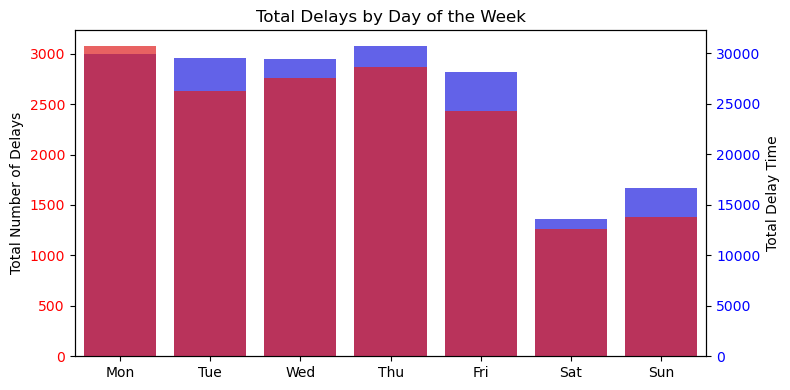

In [ ]:
#created new df because I didnt want totaldelaytime as a column in original
# grped by day of the week and aggregates the total delays and counts
day_delay_summ = df.groupby('WeekDay').agg(
    DelayCount=('registered delay', 'count'),
    TotalDelayTime=('registered delay', 'sum')
).reset_index()

#order x axis from mon to sun
day_delay_summ['WeekDay'] = pd.Categorical(day_delay_summ['WeekDay'], categories=day_names, ordered=True)

# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))

# DelayCount on the fst axis
sb.barplot(x='WeekDay', y='DelayCount', data=day_delay_summ, color="blue", alpha=0.7, ax=ax1)

ax1.set_xlabel("")
ax1.set_ylabel("Total Number of Delays")
ax1.set_title("Total Delays by Day of the Week")
ax1.tick_params(axis='y', labelcolor="red")

# snd axis
ax2 = ax1.twinx()

# TotalDelayTime on the snd axis
sb.barplot(x='WeekDay', y='TotalDelayTime', data=day_delay_summ, color="red", ax=ax2, alpha=0.7)

ax2.set_ylabel("Total Delay Time")
ax2.tick_params(axis='y', labelcolor="blue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [234]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, f1_score, precision_score
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df['Place_encoded'] = le.fit_transform(df['Place'])

#df = df[df['registered delay'] <= 60]

x = df.drop(columns=["Punctual", "Date", "Place", "Route", "Route_encoded", "registered delay", "RouteDelayCount", "Place_encoded", "DelayInterval"])
y_reg = df["registered delay"]
y_clas = df["Punctual"]
y_multi_clas = df["DelayInterval"]

print(x)


       Tågnr  Route number  WeekDay  IsWeekend  TrainDelayCount  \
0       7123          3165        0      False               64   
1       7123          3165        0      False               64   
2       7165          3167        0      False               22   
3       7410          3160        0      False              195   
5       7410          3160        0      False              195   
...      ...           ...      ...        ...              ...   
17829   7413          3161        3      False               53   
17830   7413          3161        3      False               53   
17831   7470          3162        3      False                7   
17832   7514          3168        3      False              174   
17833   8351          3005        3      False               91   

       PlaceDelayCount  
0                   13  
1                  282  
2                   24  
3                   55  
5                   83  
...                ...  
17829               

In [225]:
x_train, x_test, y_train, y_test = train_test_split(x, y_reg, test_size=0.3, random_state=42)

In [222]:
regressor = RandomForestRegressor(random_state=42)
regressor.fit(x_train, y_train)

pred_reg = regressor.predict(x_test)

mae = mean_absolute_error(y_test, pred_reg)
mse = mean_squared_error(y_test, pred_reg)


print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 5.2087125127609255
Mean Squared Error: 71.72611773464364


I've used mean error because I want to know what the error between the predicted and actual values is to asses the performance of the model.

In [226]:
x_train, x_test, y_train, y_test = train_test_split(x, y_clas, test_size=0.3, random_state=42)

In [227]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(x_train, y_train)

pred_clas = classifier.predict(x_test)

accuracy = accuracy_score(y_test, pred_clas)
f1 = f1_score(y_test, pred_clas)
precision = precision_score(y_test, pred_clas)


print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precisions Score: {precision}")

Accuracy Score: 0.6115530303030303
F1 Score: 0.6171364569721859
Precisions Score: 0.6323641928079572


In [235]:
x_train, x_test, y_train, y_test = train_test_split(x, y_multi_clas, test_size=0.3, random_state=42)

In [236]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(x_train, y_train)

pred_clas = classifier.predict(x_test)

accuracy = accuracy_score(y_test, pred_clas)
f1 = f1_score(y_test, pred_clas, average='weighted')
precision = precision_score(y_test, pred_clas, average='weighted')


print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precisions Score: {precision}")

Accuracy Score: 0.5526515151515151
F1 Score: 0.5357545725547104
Precisions Score: 0.5238831916428499
